In [2]:
import DELightStyle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np #needed for dummy datasets only
import os #needed for join path and filenames when saving plots
from matplotlib.gridspec import GridSpec
from TraceSimulator import TraceSimulator
import yaml

plt.rcParams['font.family'] = 'DejaVu Sans'  # Matplotlib's default font
def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('../../../trigger_study/archive/config.yaml')
ts = TraceSimulator(config)

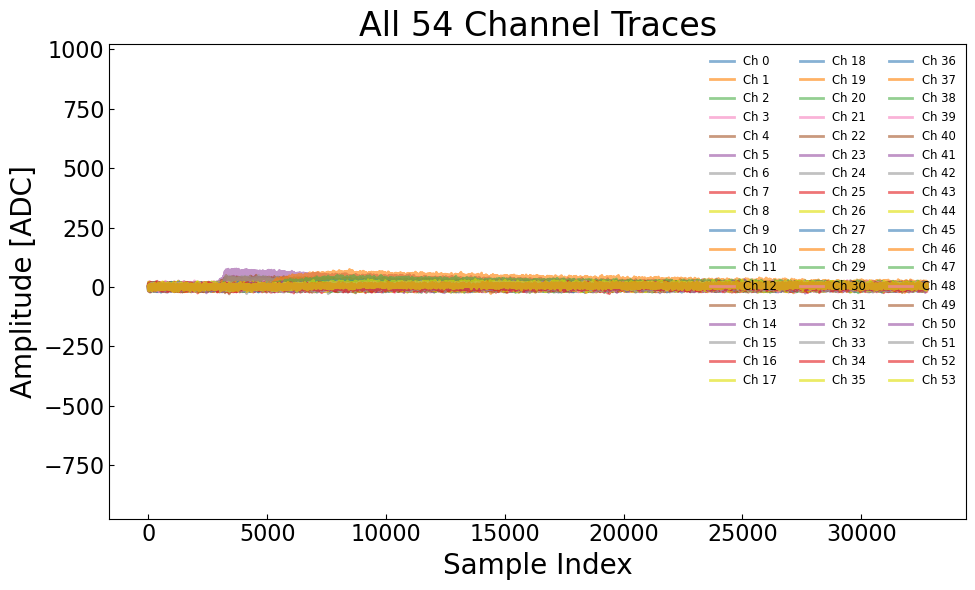

In [22]:
trace=ts.generate(E=500, x=-40, y=80, z=-1800, no_noise=False, type_recoil='NR', quantize=False, phonon_only=False)
plt.figure(figsize=(10, 6))
for i in range(54):
    plt.plot(trace[0][i], alpha=0.6, label=f"Ch {i}")
plt.gca().set_aspect(10, adjustable='datalim')

plt.xlabel("Sample Index")
plt.ylabel("Amplitude [ADC]")
plt.title("All 54 Channel Traces")
plt.legend(ncol=3, fontsize='small', loc='upper right')  # adjust as needed
plt.tight_layout()
plt.show()

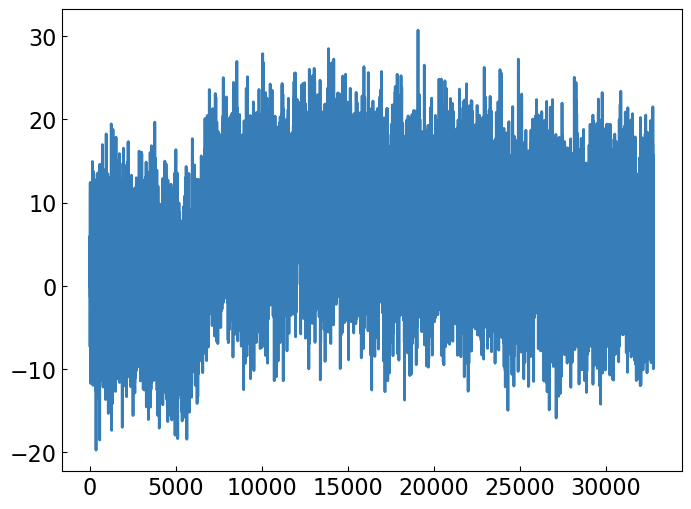

In [23]:
plt.plot(trace[0][45])

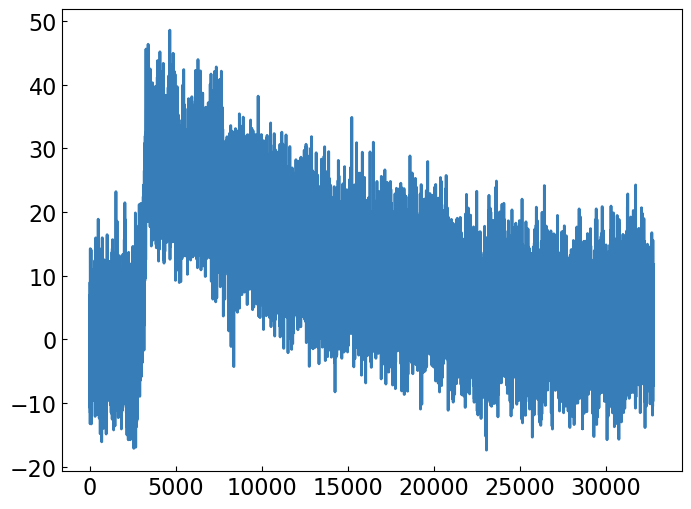

In [27]:
plt.plot(trace[0][33])

TEMPLATE FITTING RESULTS

channel 33 (Submerged):
  Amplitude: 31.379072[ADC]
  Chi-square: 0.994010
  Time shift: 4.000000 samples (0.001024 ms)

channel 45 (vacuum_type0):
  Amplitude: 9.783799[ADC]
  Chi-square: 0.994843
  Time shift: 2251.000000 samples (0.576256 ms)

channel 46 (vacuum_type1):
  Amplitude: 37.939390[ADC]
  Chi-square: 1.037753
  Time shift: -2287.000000 samples (-0.585472 ms)


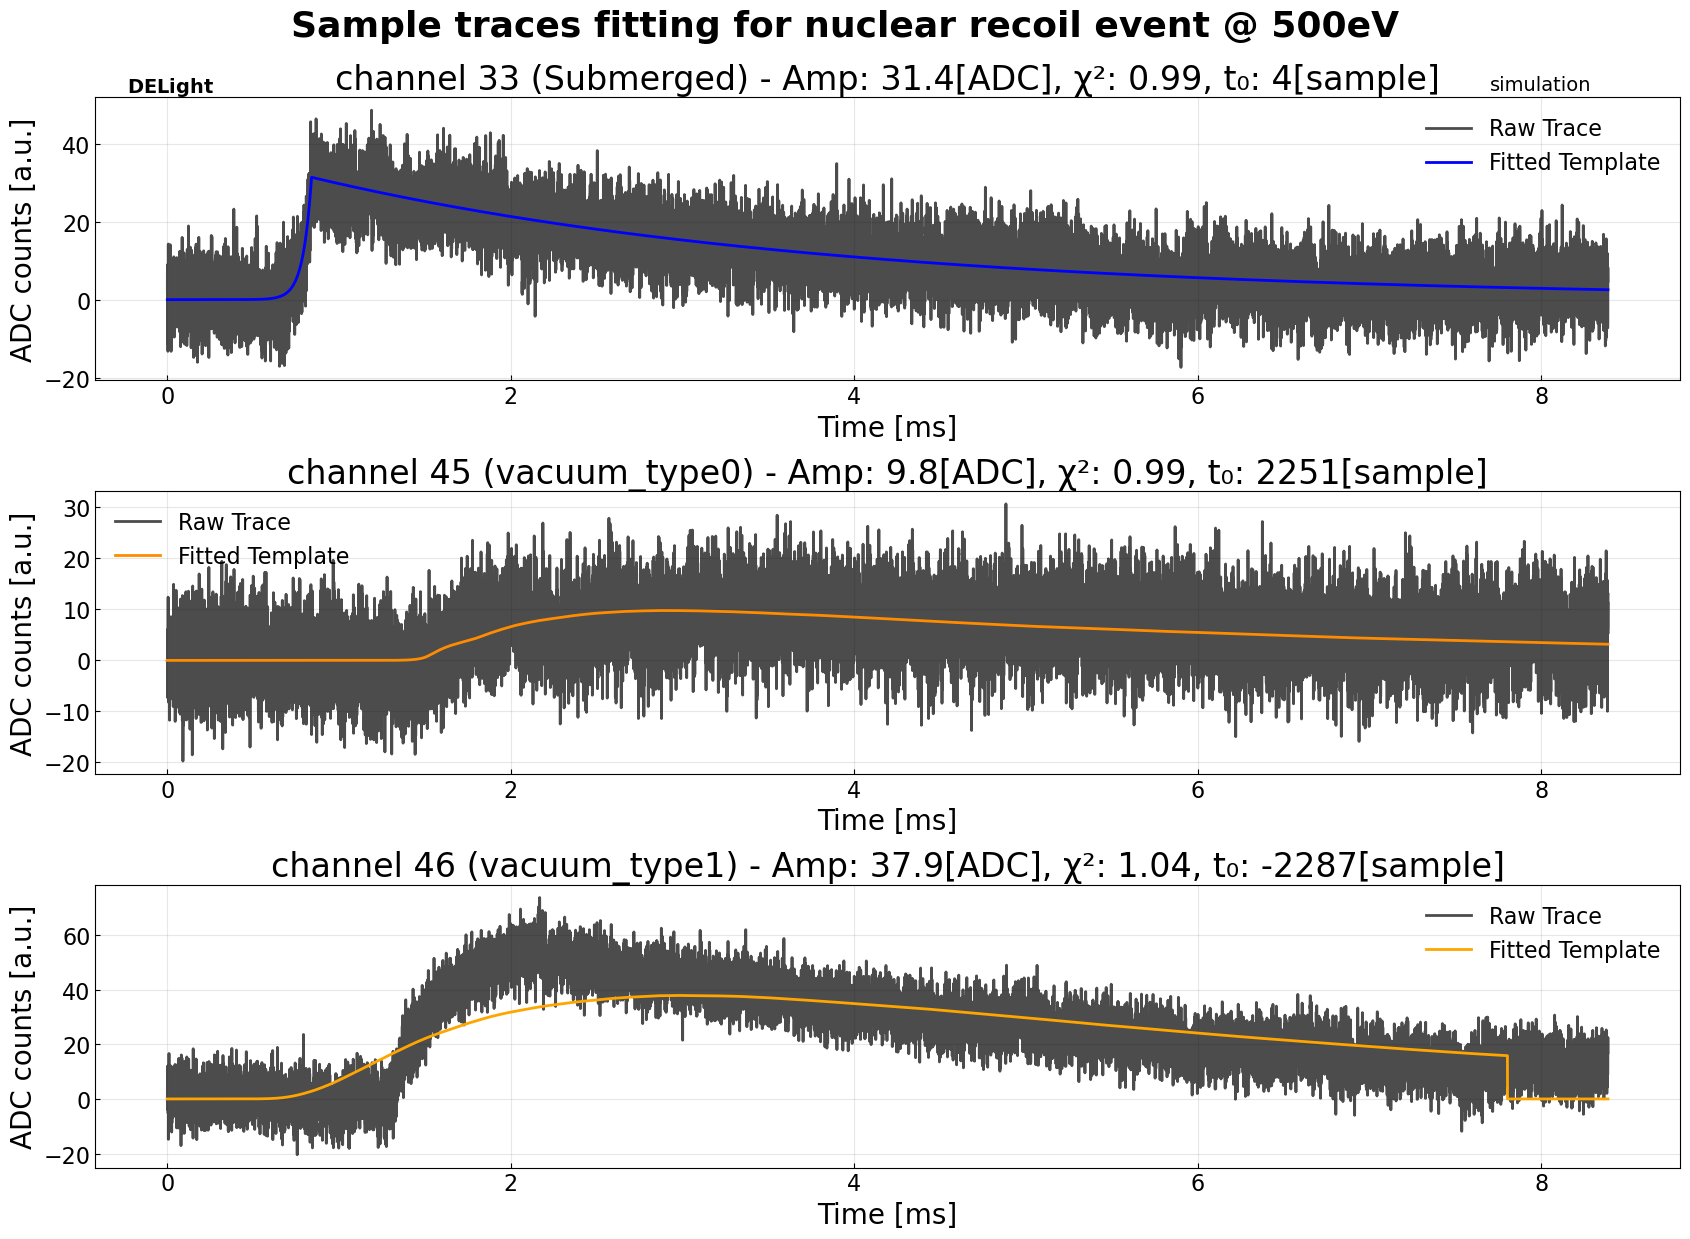


FITTING SUMMARY
Channel    Amplitude    Chi-square   Time Shift (ms)
------------------------------------------------------------
33         31.379072    0.994010     0.001024       
45         9.783799     0.994843     0.576256       
46         37.939390    1.037753     -0.585472      


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from OptimumFilter import *

# Parameters
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # Time step in ms
time_axis = np.arange(32768) * dt_ms  # Assuming traces have length 32768

# Load templates and PSD
uv_template = np.load("sub_ch_template.npy")
mmc_psd = np.load("../../../templates/noise_psd_from_MMC.npy")
qp1_template = np.load("../../../templates/vac_templates/vac_ch45_low_eng.npy")
qp2_template = np.load("../../../templates/vac_templates/vac_ch46plus_low_eng.npy")

# Initialize triggers
sub_trigger = OptimumFilter(uv_template, mmc_psd, sampling_frequency)
qp1_trigger = OptimumFilter(qp1_template, mmc_psd, sampling_frequency)
qp2_trigger = OptimumFilter(qp2_template, mmc_psd, sampling_frequency)

# Assuming you have a trace loaded (you'll need to replace this with your actual trace)
# trace = your_loaded_trace_here

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(17, 13))

# Channel mappings and trigger info
channels = [33, 45, 46]
triggers = [sub_trigger, qp1_trigger, qp2_trigger]
templates = [uv_template, qp1_template, qp2_template]
labels = ['channel 33 (Submerged)', 'channel 45 (vacuum_type0)', 'channel 46 (vacuum_type1)']
colors = ['blue', 'darkorange', 'orange']

print("=" * 60)
print("TEMPLATE FITTING RESULTS")
print("=" * 60)

for i, (ch, trigger, template, label, color) in enumerate(zip(channels, triggers, templates, labels, colors)):
    # Get the trace for this channel
    raw_trace = trace[0][ch]
    
    # Fit with shift
    ampl, chisq, t0 = trigger.fit_with_shift(raw_trace)
    
    # Print fitting results
    print(f"\n{label}:")
    print(f"  Amplitude: {ampl:.6f}[ADC]")
    print(f"  Chi-square: {chisq:.6f}")
    print(f"  Time shift: {t0:.6f} samples ({t0 * dt_ms:.6f} ms)")
    
    # Create fitted template (shifted and scaled)
    # Shift the template by t0 samples
    if t0 >= 0:
        # Positive shift - pad beginning with zeros
        shift_samples = int(round(t0))
        fitted_template = np.zeros_like(template)
        if shift_samples < len(template):
            fitted_template[shift_samples:] = template[:-shift_samples] if shift_samples > 0 else template
    else:
        # Negative shift - pad end with zeros
        shift_samples = int(round(-t0))
        fitted_template = np.zeros_like(template)
        if shift_samples < len(template):
            fitted_template[:-shift_samples] = template[shift_samples:] if shift_samples > 0 else template
    
    # Scale by amplitude
    fitted_template *= ampl
    
    # Create time axis for this trace
    time_trace = np.arange(len(raw_trace)) * dt_ms
    time_template = np.arange(len(fitted_template)) * dt_ms
    
    # Plot
    axes[i].plot(time_trace, raw_trace, label='Raw Trace', color='black', linewidth=2, alpha=0.7)
    axes[i].plot(time_template, fitted_template, label='Fitted Template', color=color, linewidth=2)
    
    axes[i].set_title(f'{label} - Amp: {ampl:.1f}[ADC], χ²: {chisq:.2f}, t₀: {t0:d}[sample]')
    axes[i].set_xlabel('Time [ms]')
    axes[i].set_ylabel('ADC counts [a.u.]')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Add DELightStyle elements to the first subplot
DELightStyle.display_text(axes[0], r'$\mathbf{DELight}$', x0=0.02, y0=1.08)
DELightStyle.display_text(axes[0], "simulation", x0=0.88, y0=1.08)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space at top for title
fig.suptitle("Sample traces fitting for nuclear recoil event @ 500eV", fontsize=26, fontweight='bold')
plt.show()

print("\n" + "=" * 60)
print("FITTING SUMMARY")
print("=" * 60)
print(f"{'Channel':<10} {'Amplitude':<12} {'Chi-square':<12} {'Time Shift (ms)':<15}")
print("-" * 60)

# Re-run fitting for summary table (in practice, you'd store results from above)
for ch, trigger, label in zip(channels, triggers, labels):
    raw_trace = trace[0][ch]
    ampl, chisq, t0 = trigger.fit_with_shift(raw_trace)
    print(f"{ch:<10} {ampl:<12.6f} {chisq:<12.6f} {t0 * dt_ms:<15.6f}")